In [240]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import copy
from math import pi, sin, cos, tan, atan, atan2

In [ ]:
'''
Credit to __ for the theory of the intersection proof below and 
and __ for the implementation in python.
See: https://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect
'''

def np_cross_product(a, b):
    return a[0]*b[1]-a[1]*b[0]

def np_seg_intersect(a, b, considerCollinearOverlapAsIntersect = False):
    # https://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect/565282#565282
    # http://www.codeproject.com/Tips/862988/Find-the-intersection-point-of-two-line-segments
    
    r = a[1] - a[0] # vector representation of segment A
    s = b[1] - b[0] # vector representation of segment B
    v = b[0] - a[0]
    # Calculate 2D cross products
    num = np_cross_product(v, r)
    denom = np_cross_product(r, s)
#     # If r x s = 0 and (q - p) x r = 0, then the two lines are collinear. --> Never the case in this implementation
#     if np.isclose(denom, 0) and np.isclose(num, 0):
#         return None
    if np.isclose(denom, 0) and not np.isclose(num, 0):
        # Parallel and non intersecting
        return None
    u = num / denom
    t = np_cross_product(v, s) / denom
    if u >= 0 and u <= 1 and t >= 0 and t <= 1:
        res = b[0] + (s*u)
        return res
    # Otherwise, the two line segments are not parallel but do not intersect.
    return None

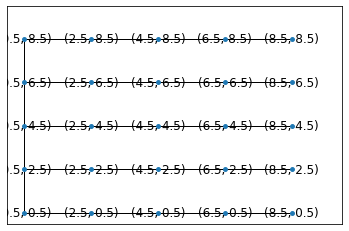

In [61]:
# Step 1: Define grid parameters
grid_lims  = np.array([[0,10], [0,10]]) # [m]
resolution = 1 # [m]
rmax, cmax = ((grid_lims[:,1]-grid_lims[:,0])/resolution).astype(int)

# Step 2: Define macro-grid -- one macro grid square holds a 2x2 base grid squares
        # Define nodes at the center of macro grid squares
ROWMAX, COLUMNMAX = ((grid_lims[:,1]-grid_lims[:,0])/resolution/2).astype(int)
macro_graph = nx.grid_2d_graph(ROWMAX,COLUMNMAX)

pos = dict( ( (i,j), (2*i+1/2, 2*(COLUMNMAX-1-j)+1/2) ) for
               (i,j) in np.ndindex(ROWMAX, COLUMNMAX))
for (i,j) in np.ndindex(ROWMAX, COLUMNMAX):
    this_pos = pos[i,j]
    macro_graph.nodes[(i,j)]["pos"] = this_pos
    


# Step 3: Find minimum spanning tree
tree = nx.minimum_spanning_tree(macro_graph)
nx.relabel_nodes(tree,pos,False)

plt.figure()
nx.draw_networkx(tree, pos=nx.get_node_attributes(tree,'pos'), 
                 with_labels=True, node_size = 15)
plt.xlim([0,rmax])
plt.ylim([0,cmax])
plt.xticks(range(rmax))
plt.axis('on')
plt.show()


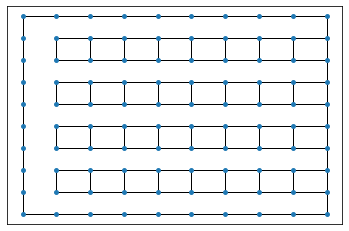

In [157]:
grid = nx.grid_2d_graph(rmax,cmax)
for i,j in np.ndindex(rmax,cmax):
    grid.nodes[(i,j)]["pos"] = (i,cmax-1-j)
    
G = copy.deepcopy(grid.edges)
for edge in G:
    for path in tree.edges:
        # Intersection test
        if np_seg_intersect(np.array(edge), np.array(path)) is not None:
            grid.remove_edge(*edge)
            
nx.draw_networkx(grid, pos=nx.get_node_attributes(grid,'pos'), 
                 with_labels=False, node_size = 15)

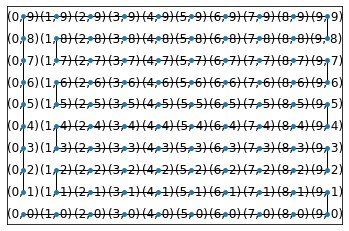

In [295]:
def done(neighbors, path):
    for node in neighbors:
        # If we find any neighbor not in the path, you can move forward.
        if node not in path.nodes:
            return False
    # If all neighbors are already in path, you're done!
    return True

def best_move(my_pos, my_heading, path, bias=pi/3):
    neighbors = list(grid.neighbors(my_pos))
    # Check if we're out of valid neighbors
    if done(neighbors, path):
        return None
    # Otherwise find best choice
    direction = []
    cost = []
    for node in neighbors:
        # We want to ignore nodes that we've already passed
        if node in path.nodes:
            direction.append(float('inf'))
            cost.append(float('inf'))
        else:
            diff = np.array(node) - np.array(my_pos)
            direction.append(atan2(diff[1],diff[0]))
            cost.append( abs(direction[-1]-(my_heading+bias)) )
            if cost[-1]<0:
                cost[-1] += 2*pi # consider left turns only --> like walking with your hand on the left wall
    choice = np.argmin(cost)
    goal_pos = neighbors[choice]
    goal_heading = direction[choice]
    
#     if path.nodes[my_pos]["pos"][0]==9:
#         print( ("pos: {}  heading: {:3.3f}  neighbors: {}\ncost: {}  direction: {}  choice: {}\n"
#                 "goal_pos: {}  goal_heading: {:3.3f}\n\n" ).format(
#               my_pos, my_heading*180/pi, neighbors, np.array(cost)*180/pi, 
#             np.array(direction)*180/pi, choice, goal_pos, goal_heading*180/pi
#              ))
    return goal_pos, goal_heading
    

path = nx.Graph()
path.add_node((0,0), pos=(0,0))

my_pos = (0,0)
my_heading = 0
bias = pi/3

# Negative bias for first step -- first find the wall, then bias left turns
goal_pos, goal_heading = best_move(my_pos, my_heading, path, bias=-bias)
path.add_node(goal_pos, pos=goal_pos)
path.add_edge(my_pos, goal_pos)
my_pos = goal_pos
my_heading = goal_heading

# Keep hand on same side of "wall"
neighbors = list(grid.neighbors(my_pos))
while( True ):
    move = best_move(my_pos, my_heading, path, bias=bias)
    if move is None:
        break
    else:
        goal_pos, goal_heading = move
    
    # picar.to_waypoint(goal)
    path.add_node(goal_pos, pos=goal_pos)
    path.add_edge(my_pos, goal_pos)
    my_pos = goal_pos
    my_heading = goal_heading
    

nx.draw_networkx(path, pos=nx.get_node_attributes(path,'pos'), 
                 with_labels=True, node_size = 15)

In [296]:
nx.write_edgelist(path, "HW5_path.edgelist")

In [282]:
path = nx.Graph()
path.add_node((0,0), pos=(0,0))

my_pos = (0,0)
my_heading = 0
bias = pi/3

# Negative bias for first step -- first find the wall, then bias left turns
goal_pos, goal_heading = best_move(my_pos, my_heading, path, bias=-bias)
path.add_node(goal_pos, pos=goal_pos)
path.add_edge(my_pos, goal_pos)
my_pos = goal_pos
my_heading = goal_heading

In [278]:
pos, h = best_move(my_pos, my_heading, path, bias)
print(pos, h*180/pi)

TypeError: cannot unpack non-iterable NoneType object

In [284]:
path = nx.Graph()
path.add_node((0,0), pos=(0,0))

my_pos = (0,0)
my_heading = 0
bias = pi/3
pos, h = best_move(my_pos, my_heading, path, -bias)
print(pos, h*180/pi)

(1, 0) 83.6598082540901


In [292]:
m = np.array(goal_pos)-np.array(my_pos)
atan2(m[1],m[0])

0.0

In [ ]:
m